## Por que usar algoritmos de otimização?
- Os algoritmos de otimização são usados quando meu universo de soluções para um determinado problema é muito grande,
tornando impraticável usar uma força bruta para tentar encontrar a melhor
- No caso do exemplo abaixo, é possível ter cerca de 300 milhões de resultados diferentes

### Qual o problema?
Um grupo de amigos que mora em diferentes estados irão para um mesmo evento na cidade de guarulhos.
Como forma de diminuir os custos, eles pretendem se reunir no aeroporto de guarulhos para pegar um mesmo transporte e dividir os custos, tanto no ida como na volta do evento.
Portanto eles precisam descobrir qual o melhor horário de voo que cada um deve tomar, saindo dos seus estados de origem, para chegar no aeroporto de guarulhos sem ter que esperar muito tempo lá, até que todos cheguem para que eles possam ir no evento

### Objetivo
- Criar uma agenda ÓTIMA de voos que tem como origem diferentes estados e destino à guarulhos e vice e versa
- Nesse caso eu não tenho uma solução definitiva ou resultado claro, portanto eu preciso executar meu algoritmo até encontrar a melhor solução dentro daquelas que foram encontradas
- É provável que não seja literalmente A MELHOR, porém é suficientemente boa
- O contrário disso seria por exemplo se eu QUISESSE que todos gastassem até R$200 e esperassem no máximo 1 hora no aeroporto

### Representação
Definição das variáveis iniciais que irão ser usadas para o problema e da variável que deverá ser otimizada 
(agenda)

In [1]:
import time
import random
import math
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

pessoas = [('Amanda', 'CWB'),
           ('Pedro', 'GIG'),
           ('Marcos', 'POA'),
           ('Priscila', 'FLN'),
           ('Jessica', 'CNF'),
           ('Paulo', 'GYN')]

destino = 'GRU'

voos = {}

### Criação do dict de voos
A partir do arquivo **voos.txt** iremos fazer um for para ler as suas linhas e pegar os horários e preço de
cada um dos voos

In [2]:
for linha in open('voos.txt'):
    _origem, _destino, _saida, _chegada, _preco = linha.split(',')
    voos.setdefault((_origem, _destino), [])
    voos[(_origem, _destino)].append((_saida, _chegada, int(_preco)))

### Função de imprimir agenda
Função final, que vai basicamente imprimir o resultado final do voo que cada pessoa vai tomar, baseado na agenda que ela recebeu, o desafio está justamente em otimizar essa agenda

In [3]:
def get_ida_volta(i, id_voo, solucao):
    origem = pessoas[i][1]
    id_voo += 1
    ida = voos[(origem, destino)][solucao[id_voo]]
    id_voo += 1
    volta = voos[(destino, origem)][solucao[id_voo]]
    
    return ida, volta

In [4]:
def imprimir_agenda(agenda):
    id_voo = -1
    for i in range(len(agenda) // 2):
        nome = pessoas[i][0] 
        origem = pessoas[i][1]
        ida, volta = get_ida_volta(i, id_voo, agenda)
        print('%10s%10s %5s-%5s R$%3s %5s-%5s R$%3s' % (nome, origem, ida[0], ida[1], ida[2],
                                                       volta[0], volta[1], volta[2]))
        id_voo += 2

In [5]:
agenda = [1,4, 3,2, 7,3, 6,3, 2,4, 5,3] ##Exemplo aleatório de agenda / solução
imprimir_agenda(agenda) 

    Amanda       CWB  8:04-10:11 R$ 95 12:08-14:05 R$142
     Pedro       GIG 10:30-14:57 R$290  9:49-13:51 R$229
    Marcos       POA 17:08-19:08 R$262 10:32-13:16 R$139
  Priscila       FLN 15:34-18:11 R$326 11:08-14:38 R$262
   Jessica       CNF  9:42-11:32 R$169 12:08-14:47 R$231
     Paulo       GYN 13:37-15:08 R$250 11:07-13:24 R$171


In [6]:
def get_minutos(hora): #transforma as horas em minutos
    x = time.strptime(hora, '%H:%M')
    minutos = x[3] * 60 + x[4]
    return minutos

## Função de custo
- É basicamente o coração dos algoritmos de otimização
- Eu transformo todas as minhas variáveis (dimensões) em um único valor, que vai expressar matematicamente o quão bom ou quão ruim é a solução encontrada

## Função de custo para os voos
- Nesse caso as minhas principais variáveis serão o **PREÇO** e **TEMPO**, ambas devem serem expressadas em um 
único valor que deverá ser minimizado (quanto mais barato e menos tiver que esperar melhor)
- Cada problema é muito particular e tem sua própria função de custo
- Nesse caso, nós assumimos que as pessoas só vão deixar o aeroporto para ir ao evento quando TODOS chegarem e só iram deixar o evento e ir ao aeroporto quando O PRIMEIRO tiver que pegar o voo

In [7]:
def aplicar_penalidade(ultima_chegada, primeira_partida):
    penalidade = 0
    if ultima_chegada > primeira_partida:
        penalidade += 50
        
    return penalidade

In [8]:
def funcao_custo(solucao):
    preco_total = 0
    ultima_chegada = 0
    primeira_partida = 1439
    custo = 0
    
    id_voo = -1
    for i in range(len(solucao) // 2):
        ida, volta = get_ida_volta(i, id_voo, solucao)
        
        preco_total += ida[2]
        preco_total += volta[2]
        
        if ultima_chegada < get_minutos(ida[1]):
            ultima_chegada = get_minutos(ida[1])
            
        if primeira_partida > get_minutos(volta[0]):
            primeira_partida = get_minutos(volta[0])
        
        id_voo += 2
            
    total_espera = 0
    id_voo = -1
    for i in range(len(solucao) // 2):
        ida, volta = get_ida_volta(i, id_voo, solucao)
        
        total_espera += ultima_chegada - get_minutos(ida[1])
        total_espera += get_minutos(volta[0]) - primeira_partida
        
        id_voo += 2
        
    custo = preco_total + total_espera   
    custo += aplicar_penalidade(ultima_chegada, primeira_partida)
        
    return custo

### Penalidade
- Podemos aplicar penalidades baseado na nossa regra de negócio, por exemplo, na função de custo em questão, 
caso o grupo de amigos tenha que dormir no local (passe para o dia seguinte) a gente adicionar +50 como penalidade.

In [9]:
funcao_custo(agenda) #meu objetivo será minimizar esse valor (cada minuto representa 1 real)

4635

In [10]:
def plotar_busca(resultados):
    t = np.arange(0.0, len(resultados), 1)
    
    plt.figure(figsize=(12,8))
    plt.plot(t, resultados)
    plt.show()

### Pesquisa Randômica
A pesquisa randômica é a busca por soluções de forma aleatória, geralmente é usada como uma baseline para avaliar os algoritmos de otimização

### Definição do domínio do problema
- O domínio será o universo de possibilidade que o meu problema terá, qual o RANGE do domínio do meu problema em questão.
- No caso dos voos, meu domínio é de (0,9). Sendo assim, é possível escolher qualquer número INTEIRO entre 0 e 9 e esse número será um índice no meu array de voos

In [11]:
def pesquisa_randomica(dominio, funcao_custo):
    melhor_custo = 999999999 #meu objetivo é minimizar
    custos = []
    for i in range(0, 10000): #quantidade de soluções que serão geradas

        solucao = [random.randint(dominio[i][0], dominio[i][1]) for i in range(len(dominio))]
        custo = funcao_custo(solucao)        
        if custo < melhor_custo:
            custos.append(custo)
            melhor_custo = custo
            melhor_solucao = solucao

    return melhor_solucao, custos

    Amanda       CWB 12:34-15:02 R$109  9:58-11:18 R$130
     Pedro       GIG 16:52-20:48 R$448  9:49-13:51 R$229
    Marcos       POA 18:35-20:28 R$204  8:19-11:16 R$122
  Priscila       FLN 17:07-20:04 R$291  8:23-11:07 R$143
   Jessica       CNF 18:48-21:45 R$246  9:11-10:42 R$172
     Paulo       GYN 16:51-19:09 R$147 11:07-13:24 R$171
menor custo 3669


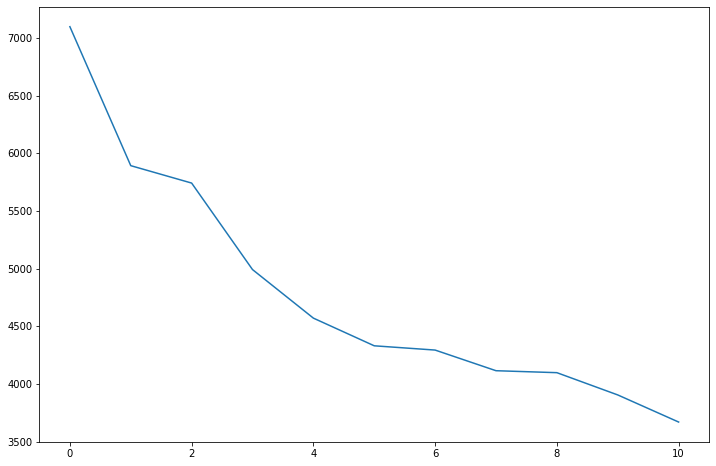

In [12]:
dominio = [(0,9)] * (len(pessoas) * 2)
solucao_randomica = pesquisa_randomica(dominio, funcao_custo)
custo_randomica = funcao_custo(solucao_randomica[0])
imprimir_agenda(solucao_randomica[0])

print('menor custo', custo_randomica)
plotar_busca(solucao_randomica[1])

### Hill Climbing
- Algoritmo de solução que usa de **Explotação** (Explora os vizinhos para tentar encontrar uma solução ótima)
- Inicializa de forma aleatória e gera uma **pequena** perturbação (delta) na nossa solução
- Faz a avaliação do novo resultado (X linha) através da função de custo
- Caso tenha melhorado (maximizado ou minimizado) o X linha vira a nova solução
- Aceita apenas positivos

In [13]:
def get_vizinhos(solucao):
    vizinhos = []
    for i in range(len(dominio)): #pegar os vizinhos de cada dimensão
        if solucao[i] > dominio[i][0]:
            if solucao[i] != dominio[i][1]:
                vizinhos.append(solucao[0:i] + [solucao[i] + 1] + solucao[i + 1:])
        if solucao[i] < dominio[i][1]:
            if solucao[i] != dominio[i][0]:
                vizinhos.append(solucao[0:i] + [solucao[i] - 1] + solucao[i + 1:])
    
    return vizinhos

Meu problema é composto de um array de inteiro, que são os voos. [3,1,4...]
No hill climbing eu preciso pegar os vizinhos, então eu adiciono um valor para cada voo. [4,2,5...]
Com isso, eu faço um movimento sutil nos horários de voo.

In [14]:
def hill_climbing(dominio, funcao_custo):
    solucao = [random.randint(dominio[i][0], dominio[i][1]) for i in range(len(dominio))] #inicia solução aleatória
    custos = []
    count = 0
    parar_no_plato = 0

    while count <= 400:
        vizinhos = get_vizinhos(solucao)
        
        atual = funcao_custo(solucao)
        melhor = atual
        solucao_atual = solucao
        custos.append(atual)

        for i in range(len(vizinhos)):
            custo = funcao_custo(vizinhos[i])
            if custo <= melhor:
                custos.append(custo)
                melhor = custo
                solucao = vizinhos[i]
                parar_no_plato += 1 if custo == melhor else 0

        count += 1
        if melhor == atual and solucao_atual == solucao or parar_no_plato == 20:
            break

    return solucao, custos

menor custo 3445
    Amanda       CWB  9:45-11:50 R$172 13:39-15:30 R$ 74
     Pedro       GIG  9:08-12:12 R$364  9:49-13:51 R$229
    Marcos       POA  8:27-10:45 R$139 13:37-15:33 R$142
  Priscila       FLN  6:25- 9:30 R$335  8:23-11:07 R$143
   Jessica       CNF  9:42-11:32 R$169 10:33-13:11 R$132
     Paulo       GYN  9:15-12:03 R$ 99  8:04-10:59 R$136


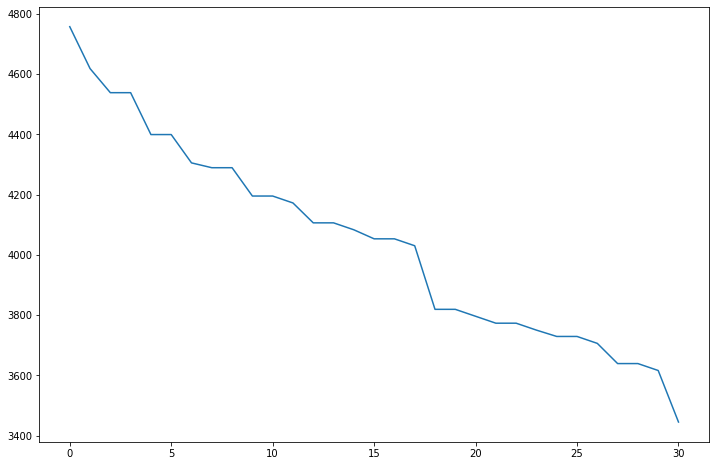

In [18]:
solucao_subida_encosta = hill_climbing(dominio, funcao_custo)
custo_subida_encosta = funcao_custo(solucao_subida_encosta[0])

print('menor custo', custo_subida_encosta)
imprimir_agenda(solucao_subida_encosta[0])
plotar_busca(solucao_subida_encosta[1])

### Simulated annealing 
Recozimento simulado é inspirado em um fenômeno da física, onde se esquenta um metal ou vidro até quase ele se liquefazer e depois se esfria devagar, para que os átomos percam a vibração aos poucos e o material fique rígido

- A diferença dele para o Hill Climbing é que ele tem uma probabilidade P de aceitar valores negativos
- Quanto mais no início do algoritmo, maior a sua chance de aceitar um valor negativo

In [16]:
def simulated_annealing(dominio, funcao_custo, temperatura = 10000.0, resfriamento = 0.95, passo = 1):
    solucao = [random.randint(dominio[i][0], dominio[i][1]) for i in range(len(dominio))]
    custos = []
    while temperatura > 0.1:
        i = random.randint(0, len(dominio) - 1) 
        direcao = random.randint(-passo, passo)
        
        solucao_temp = solucao[:]
        solucao_temp[i] += direcao
        if solucao_temp[i] < dominio[i][0]:
            solucao_temp[i] = dominio[i][0]
        elif solucao_temp[i] > dominio[i][1]:
            solucao_temp[i] = dominio[i][1]
            
        custo_solucao = funcao_custo(solucao)
        custo_solucao_temp = funcao_custo(solucao_temp)
        probabilidade = pow(math.e, (-custo_solucao_temp - custo_solucao) / temperatura)
        
        if (custo_solucao_temp < custo_solucao or random.random() < probabilidade):
            custos.append(solucao_temp)
            solucao = solucao_temp
        
        temperatura = temperatura * resfriamento
    return solucao, custos

    Amanda       CWB 18:34-19:36 R$136 10:33-12:03 R$ 74
     Pedro       GIG 18:26-21:29 R$464  6:09- 9:49 R$414
    Marcos       POA 18:35-20:28 R$204  8:19-11:16 R$122
  Priscila       FLN 18:23-21:35 R$134  6:33- 9:14 R$172
   Jessica       CNF 18:48-21:45 R$246  6:03- 8:43 R$219
     Paulo       GYN 16:51-19:09 R$147  6:19- 8:13 R$239
Menor custo 3467


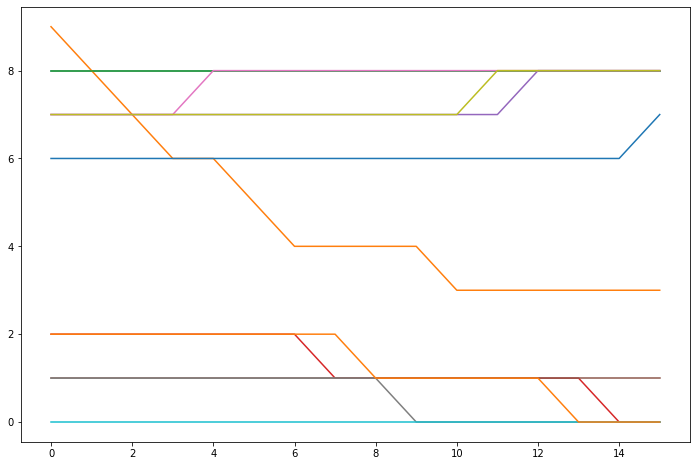

In [20]:
solucao_tempera_simulada = simulated_annealing(dominio, funcao_custo)
custo_tempera_simulada = funcao_custo(solucao_tempera_simulada[0])
imprimir_agenda(solucao_tempera_simulada[0])

print('Menor custo', custo_tempera_simulada)
plotar_busca(solucao_tempera_simulada[1])